# #EDA - Tickers de Tecnologia (2007–2025)

In [1]:
import pandas as pd
import s3fs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import pyarrow.parquet as pq



In [2]:

df_total = pd.read_csv('../datas/dados_base.csv')

#Ajustar os tipos de colunas
df_total['Date'] = pd.to_datetime(df_total['Date'])
df_total['Close'] = df_total['Close'].astype(float)
df_total['High'] = df_total['High'].astype(float)
df_total['Low'] = df_total['Low'].astype(float)
df_total['Open'] = df_total['Open'].astype(float)
df_total['Volume'] = df_total['Volume'].astype(int)
df_total['ticker'] = df_total['ticker'].astype(str)

In [ ]:
#bucket_name = 'fiap-tch3-mlet'
#prefix = 'dados_financeiros/'
# Inicializa o sistema de arquivos S3
#fs = s3fs.S3FileSystem()

# Lista todos os arquivos Parquet dentro do prefixo
#arquivos = fs.glob(f'{bucket_name}/{prefix}**/dados.parquet')
#print(f"Arquivos encontrados: {len(arquivos)}")
# Agora, carrega todos os arquivos e junta
#dfs = []

#for arquivo in arquivos:
#    print(f"Lendo {arquivo}...")

    # Abrir o arquivo
#    with fs.open(arquivo) as f:
#        table = pq.read_table(f)
#        df_temp = table.to_pandas()  # Sem types_mapper aqui

    # Agora, converte a coluna 'ticker' para string
#    if 'ticker' in df_temp.columns:
#        df_temp['ticker'] = df_temp['ticker'].astype(str)

 #   dfs.append(df_temp)


Arquivos encontrados: 133
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2007/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2008/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2009/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2010/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2011/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2012/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2013/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2014/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2015/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2016/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2017/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros/ticker=AAPL/year=2018/dados.parquet...
Lendo fiap-tch3-mlet/dados_financeiros

## 1. Informações Gerais

Aqui iniciamos com uma visão geral da base: dimensões, tipos de dados e estatísticas básicas.

In [12]:
print("Informações gerais:")
print(df_total.info())
print(df_total.describe())


Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32305 entries, 0 to 32304
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    32305 non-null  datetime64[ns]
 1   Close   32305 non-null  float64       
 2   High    32305 non-null  float64       
 3   Low     32305 non-null  float64       
 4   Open    32305 non-null  float64       
 5   Volume  32305 non-null  int64         
 6   ticker  32305 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 1.7+ MB
None
                                Date         Close          High  \
count                          32305  32305.000000  32305.000000   
mean   2016-03-02 06:06:19.111592704    449.337706    452.316474   
min              2007-01-03 00:00:00      1.751500      1.853500   
25%              2011-08-01 00:00:00     21.811575     21.997785   
50%              2016-03-03 00:00:00     88.528542

## 2. Cobertura e Intervalo por Ticker

Verificamos quantos dados existem por ativo e o período coberto para cada ticker. Isso ajuda a entender a consistência da base.

In [13]:
print("Número de registros por ticker:")
print(df_total['ticker'].value_counts())

print("\nDatas de início e fim por ticker:")
print(df_total.groupby('ticker')['Date'].agg(['min', 'max']))


Número de registros por ticker:
ticker
AAPL     4615
AMZN     4615
GOOG     4615
IBM      4615
MSFT     4615
NFLX     4615
^GSPC    4615
Name: count, dtype: int64

Datas de início e fim por ticker:
              min        max
ticker                      
AAPL   2007-01-03 2025-05-06
AMZN   2007-01-03 2025-05-06
GOOG   2007-01-03 2025-05-06
IBM    2007-01-03 2025-05-06
MSFT   2007-01-03 2025-05-06
NFLX   2007-01-03 2025-05-06
^GSPC  2007-01-03 2025-05-06


## 3. Preparação da Série Temporal

Transformamos a coluna de datas e organizamos o DataFrame com datas como índice, o que é essencial para séries temporais.

In [14]:
df_total['Date'] = pd.to_datetime(df_total['Date'])
df_total = df_total.set_index('Date').sort_index()


## 4. Evolução dos Preços de Fechamento

Visualizamos o preço de fechamento ao longo do tempo para cada ativo. Isso ajuda a identificar tendências, ciclos e eventos abruptos.

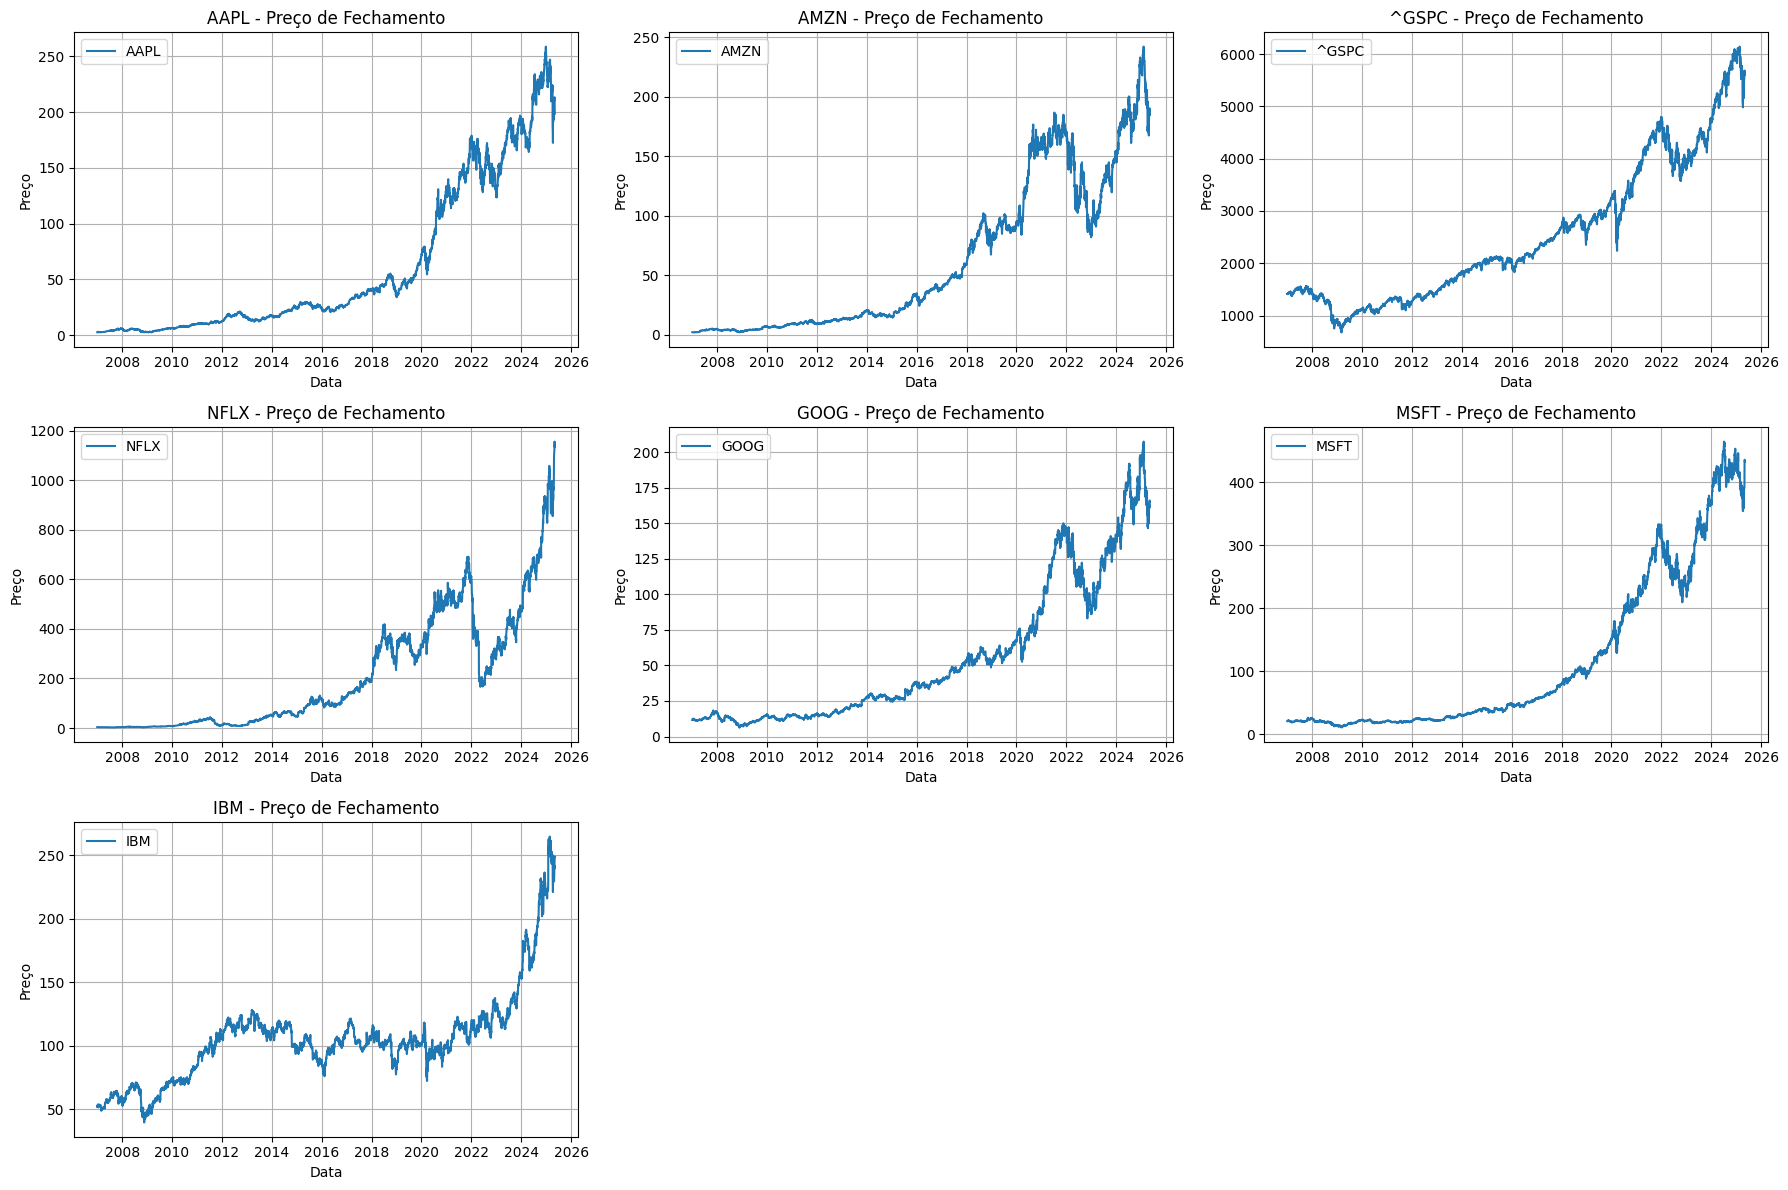

In [15]:
# Exibir painel de gráficos com preços de fechamento
import matplotlib.pyplot as plt
import numpy as np

tickers = df_total['ticker'].unique()
n = len(tickers)
cols = 3
rows = int(np.ceil(n / cols))

fig, axs = plt.subplots(rows, cols, figsize=(18, 4 * rows), sharex=False)
axs = axs.flatten()

for i, ticker in enumerate(tickers):
    df_t = df_total[df_total['ticker'] == ticker]
    axs[i].plot(df_t.index, df_t['Close'], label=ticker)
    axs[i].set_title(f'{ticker} - Preço de Fechamento')
    axs[i].set_xlabel('Data')
    axs[i].set_ylabel('Preço')
    axs[i].grid(True)
    axs[i].legend()

# Oculta subplots vazios
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.tight_layout()
plt.show()



AAPL, AMZN, MSFT, GOOG e NFLX mostram forte tendência de alta no longo prazo, refletindo o crescimento do setor tech desde 2008.

Todas as ações, especialmente NFLX e AMZN, apresentam quedas abruptas em momentos específicos:

Crises macroeconômicas (ex: COVID-19 em 2020, Tech sell-off em 2022).

Essas quedas são riscos importantes na análise de drawdown e volatilidade.

O S&P 500 cresce mais suavemente e com menor volatilidade em comparação com as ações tech.

Serve como boa referência de comparação para análise de índice Sharpe e avaliação de desempenho relativo.



## 5. Retornos Diários

Calculamos o retorno percentual diário para entender a variação dos ativos. Em seguida, observamos sua distribuição.

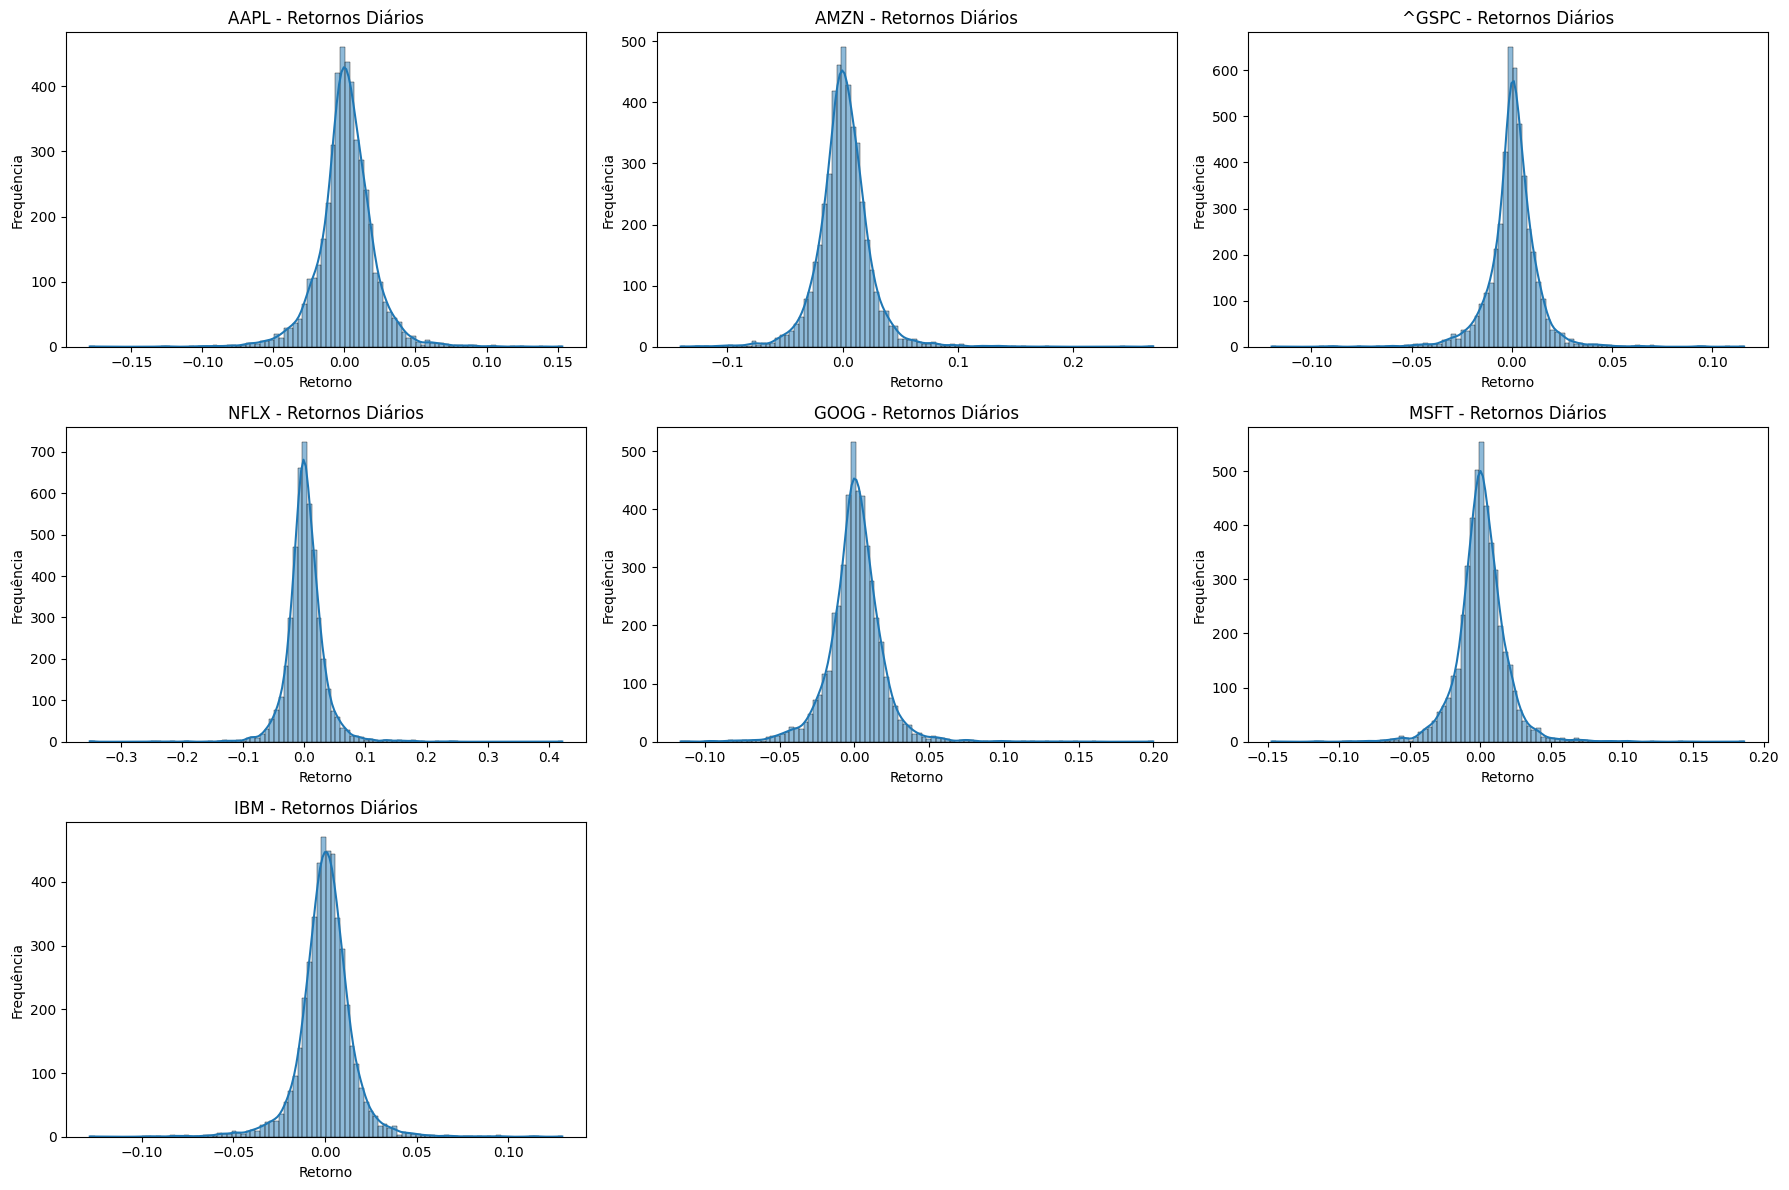

In [19]:
df_total['return'] = df_total.groupby('ticker')['Close'].pct_change()

tickers = df_total['ticker'].unique()
n = len(tickers)
cols = 3
rows = int(np.ceil(n / cols))

fig, axs = plt.subplots(rows, cols, figsize=(18, 4 * rows))
axs = axs.flatten()

for i, ticker in enumerate(tickers):
    returns = df_total[df_total['ticker'] == ticker]['return'].dropna()
    sns.histplot(returns, bins=100, kde=True, ax=axs[i])
    axs[i].set_title(f'{ticker} - Retornos Diários')
    axs[i].set_xlabel('Retorno')
    axs[i].set_ylabel('Frequência')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.tight_layout()
plt.show()



## 6. Correlação entre Ativos

Criamos uma matriz de correlação entre os retornos dos ativos. Isso mostra quais ativos se movimentam de forma parecida.

Em modelos como o de Markowitz, a correlação entre ativos é usada para reduzir o risco total da carteira.

Ao escolher ativos com baixa correlação entre si, é possível construir portfólios mais diversificados, com menor volatilidade para o mesmo retorno esperado.

Também ajuda a entender se os ativos estão expostos aos mesmos riscos sistêmicos (ex: setor, macroeconomia).

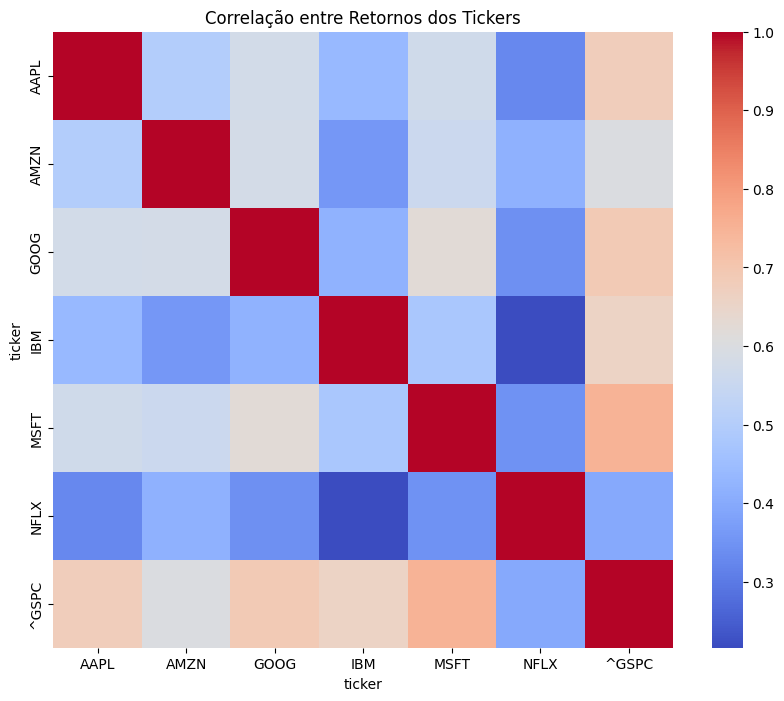

In [17]:
pivot_returns = df_total.pivot_table(values='return', index=df_total.index, columns='ticker')
correlation_matrix = pivot_returns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlação entre Retornos dos Tickers')
plt.show()


Correlações moderadas entre grandes techs:

AAPL, GOOG, MSFT e AMZN apresentam correlações moderadas (~0.5–0.6) entre si.

Isso indica que esses ativos tendem a subir e cair juntos, mas não de forma muito perfeita.

NFLX e IBM têm correlação mais fraca:

NFLX mostra baixa correlação com os demais.

Isso pode ser vantajoso para diversificação, já que os movimentos de NFLX são mais independentes.

^GSPC (S&P 500) tem correlação mais alta com MSFT e GOOG (~0.7):

Isso sugere que esses ativos têm forte influência no índice, o que é esperado, pois são empresas de grande peso no mercado.

## 7. Volatilidade ao Longo do Tempo

A volatilidade mostra o risco de um ativo.

Usamos window = 21 para usar aproximadamente 1 mês de pregão para cada ticker.

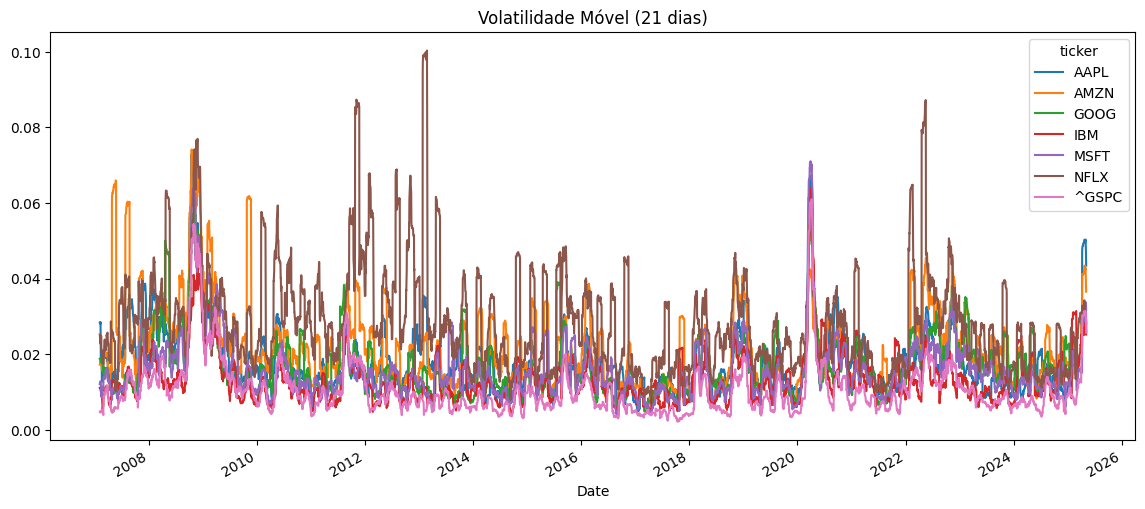

In [18]:
rolling_vol = pivot_returns.rolling(window=21).std()
rolling_vol.plot(figsize=(14, 6), title='Volatilidade Móvel (21 dias)')
plt.show()


## 8. Máximo Drawdown

Calculamos a maior perda acumulada de cada ativo a partir de um pico histórico. 

Útil para entender o pior cenário enfrentado.

É uma métrica de risco extremo, diferente da volatilidade, que mede risco médio.

In [19]:
def compute_drawdown(series):
    cum_returns = (1 + series).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    return drawdown.min()

drawdowns = pivot_returns.apply(compute_drawdown)
print("Max Drawdown por ativo:")
print(drawdowns)


Max Drawdown por ativo:
ticker
AAPL    -0.608667
AMZN    -0.652549
GOOG    -0.652948
IBM     -0.442907
MSFT    -0.579420
NFLX    -0.819904
^GSPC   -0.567754
dtype: float64


## 9. Teste de Estacionariedade (ADF)

Testamos se os preços são estacionários (ou seja, se não têm tendência). Isso é importante para muitos modelos preditivos que assumem que os dados são estacionários (ARIMA, GARCH..).

In [20]:
for ticker in df_total['ticker'].unique():
    ts = df_total[df_total['ticker'] == ticker]['Close'].dropna()
    result = adfuller(ts)
    print(f"{ticker}: ADF={result[0]:.2f}, p-valor={result[1]:.4f}")


AAPL: ADF=0.60, p-valor=0.9877
AMZN: ADF=-0.10, p-valor=0.9498
^GSPC: ADF=1.06, p-valor=0.9949
NFLX: ADF=2.37, p-valor=0.9990
GOOG: ADF=0.31, p-valor=0.9780
MSFT: ADF=1.76, p-valor=0.9983
IBM: ADF=1.31, p-valor=0.9966


Os preços geralmente não são estacionários (têm tendência).

Consideramos uma série estacionária quando p-value < 0.05

Os retornos costumam ser mais próximos de estacionários (média e variância estáveis).

Por isso, modelos costumam trabalhar com retornos em vez de preços brutos.

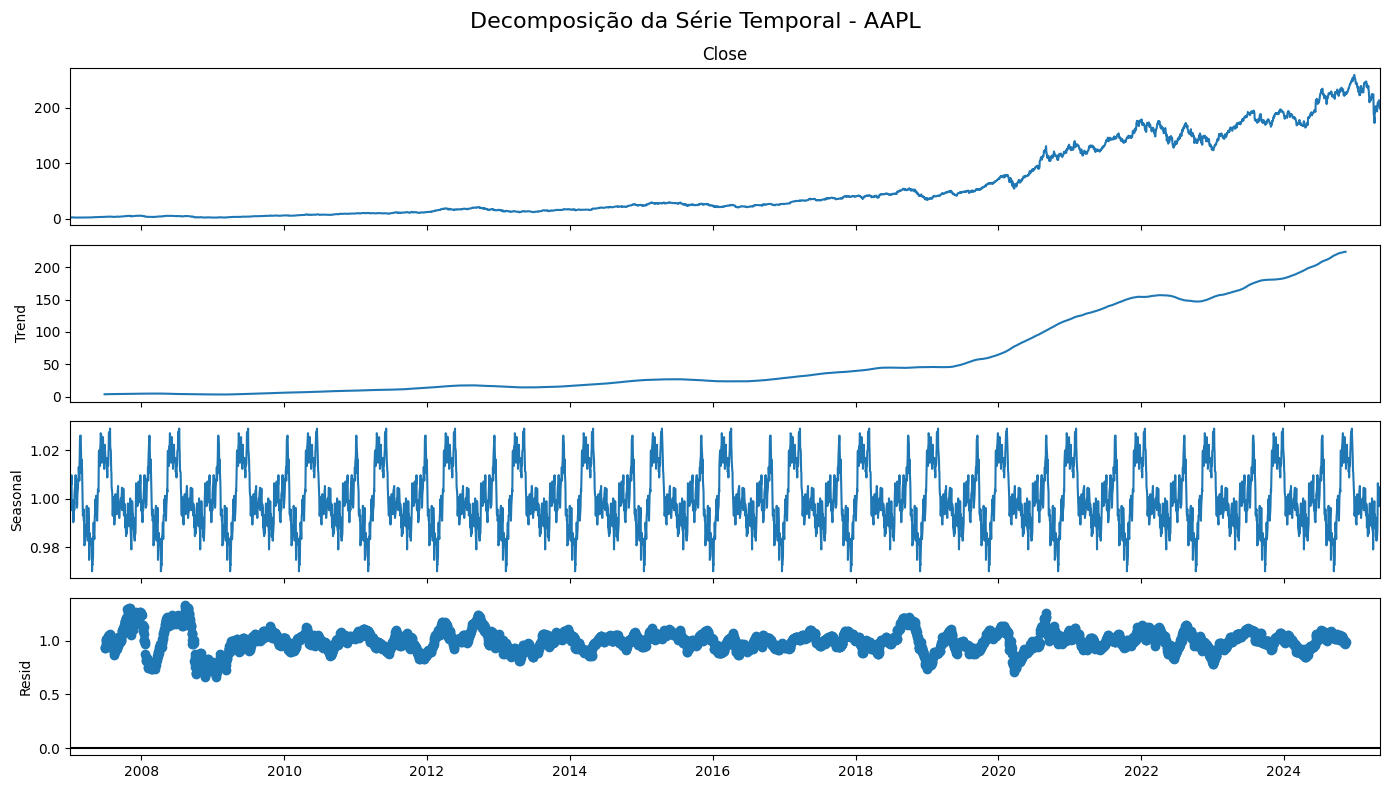

In [22]:

from statsmodels.tsa.seasonal import seasonal_decompose


# Escolha o ticker que deseja decompor
ticker_exemplo = 'AAPL'  # ou outro de sua base
df_ticker = df_total[df_total['ticker'] == ticker_exemplo]

# Converter para série temporal com frequência diária e preencher valores
ts = df_ticker['Close'].asfreq('B').interpolate()  # frequência de dias úteis com interpolação

# Decompor série temporal (tendência, sazonalidade e ruído)
decomposicao = seasonal_decompose(ts, model='multiplicative', period=252)  # ~1 ano de pregões

# Plotar
fig = decomposicao.plot()
fig.set_size_inches(14, 8)
fig.suptitle(f'Decomposição da Série Temporal - {ticker_exemplo}', fontsize=16)
plt.tight_layout()

Geramos esse gráfico para entender melhor a estrutura do comportamento histórico do preço da ação da AAPL. A decomposição separa a série original em três componentes principais: tendência, sazonalidade e ruído.

Trend (Tendência): indica o crescimento estrutural do ativo ao longo dos anos.

Seasonal (Sazonalidade): ajuda a identificar ciclos repetitivos (quando presentes). No caso da AAPL, quase inexistente.

Residual (Ruído): mostra variações imprevisíveis e eventos pontuais — essencial para avaliar risco.

Alguns modelos como ARIMA, SARIMA, Prophet, funcionam melhor quando os componentes da série estão bem definidos ou removidos. Por exemplo: é comum removermos tendência ou ajustarmos sazonalidade antes de aplicar modelos preditivos.

A decomposição ajuda a justificar decisões como:
 - usar retornos em vez de preços,
 - aplicar diferenciação,
 - usar modelos robustos a ruído.


## 10. Médias Móveis (MA20 e MA100)

Adicionamos médias móveis curtas e longas, úteis para análise de tendência e identificação de sinais de compra/venda.

In [23]:
df_total['ma_20'] = df_total.groupby('ticker')['Close'].transform(lambda x: x.rolling(window=20).mean())
df_total['ma_100'] = df_total.groupby('ticker')['Close'].transform(lambda x: x.rolling(window=100).mean())


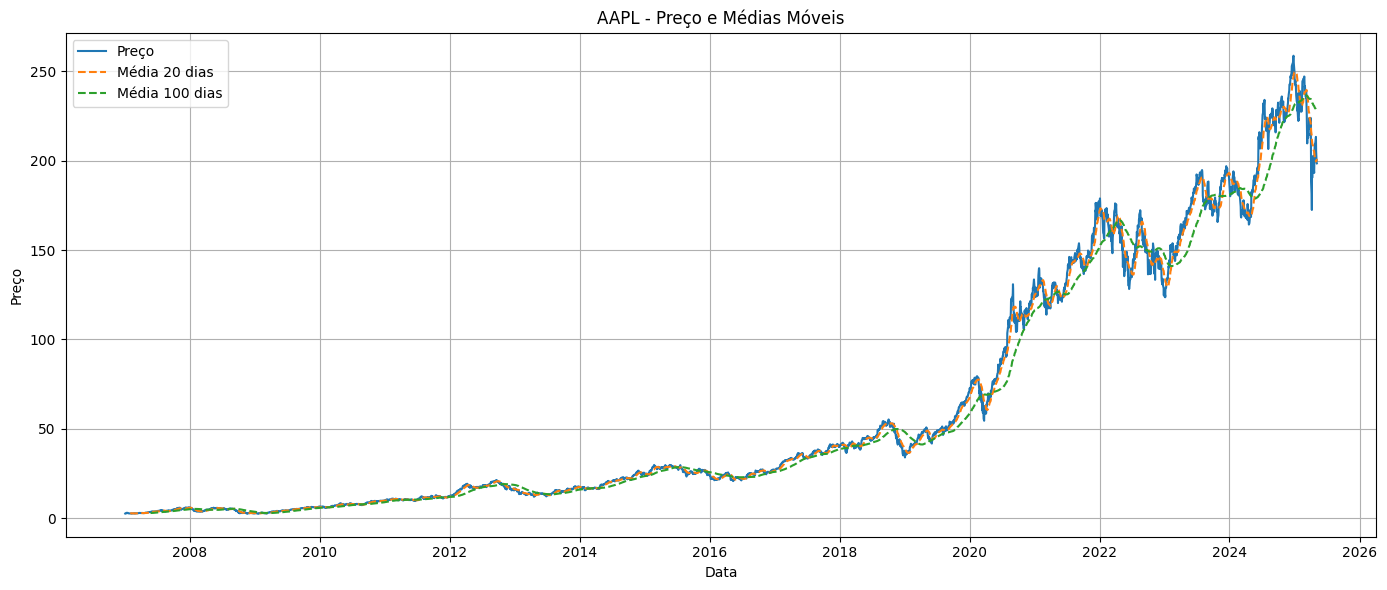

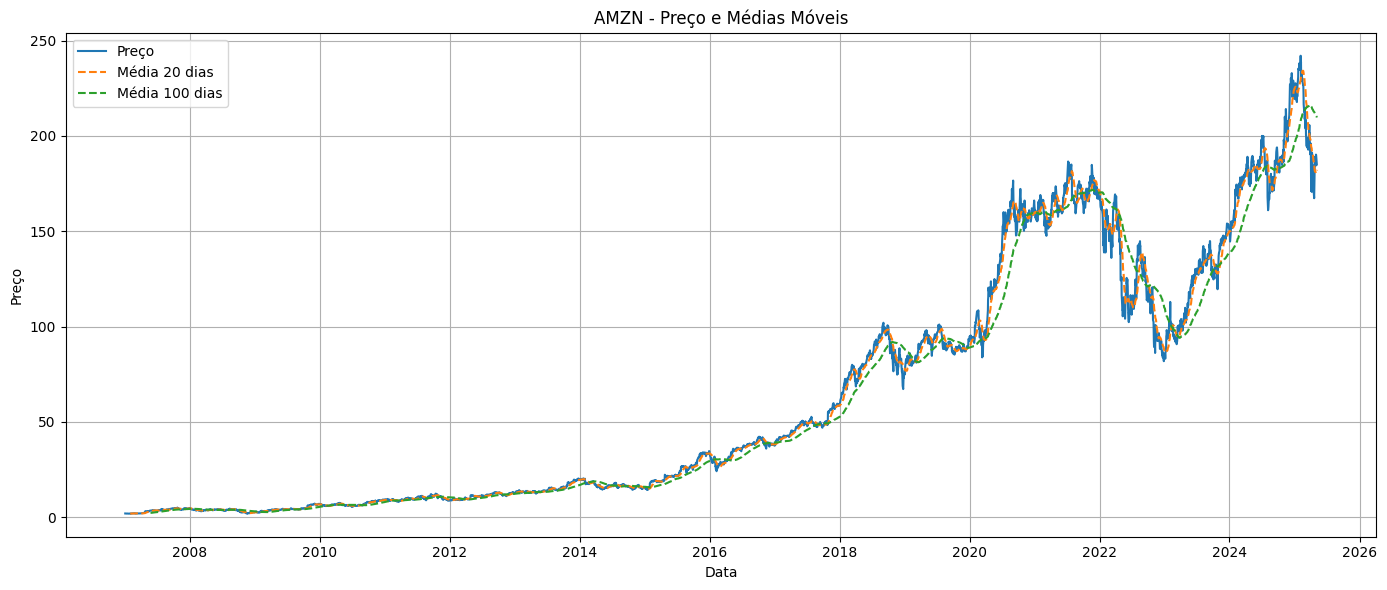

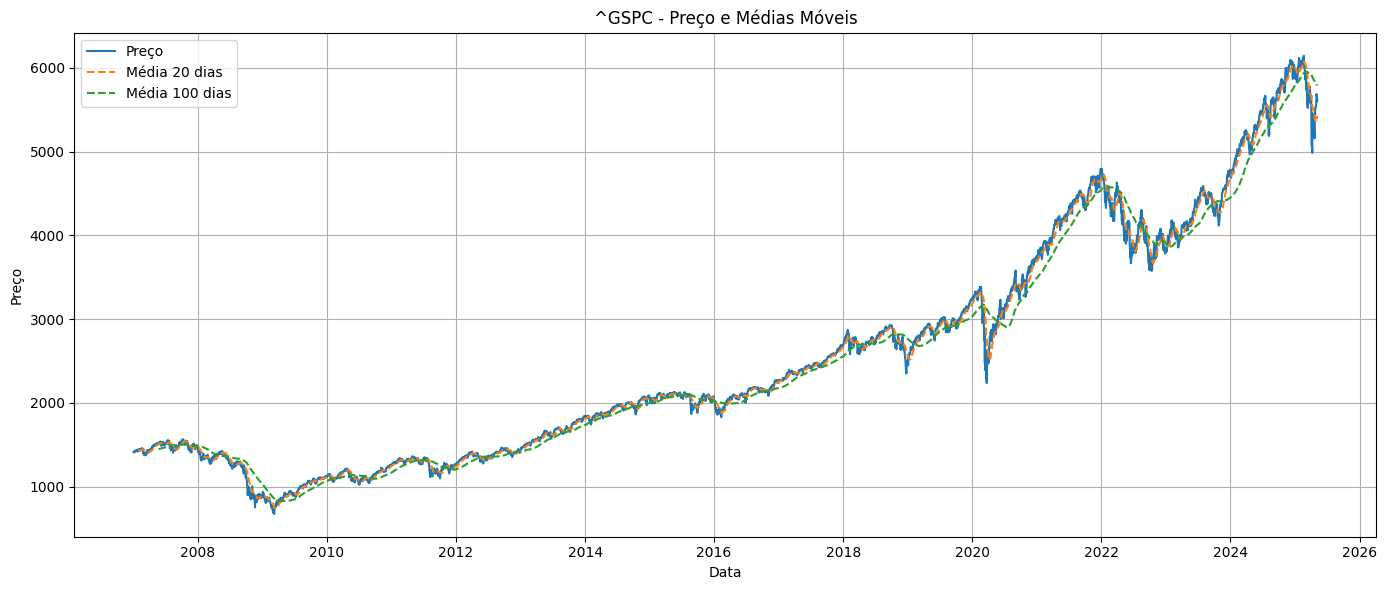

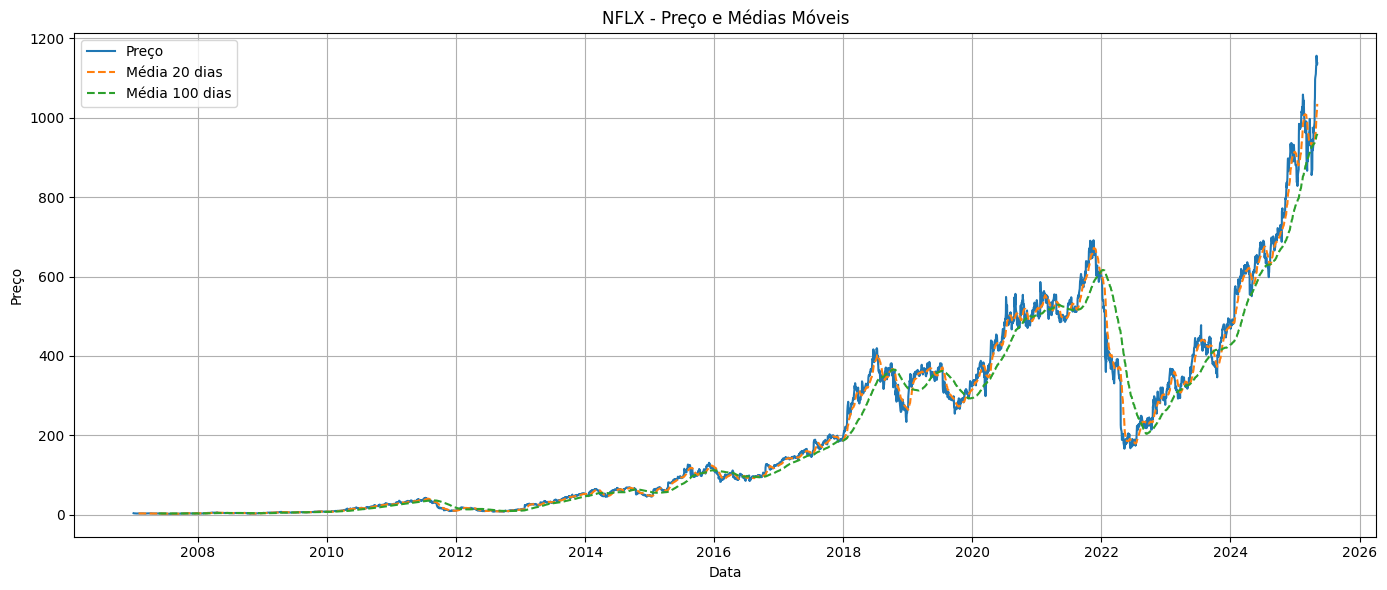

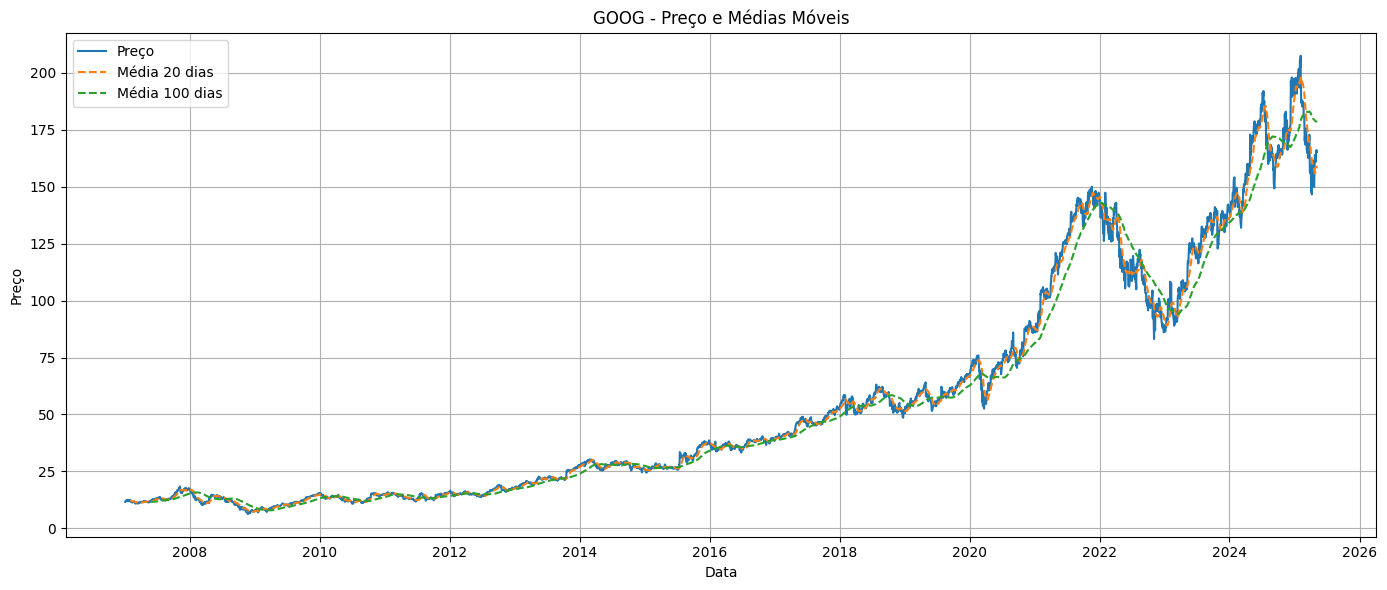

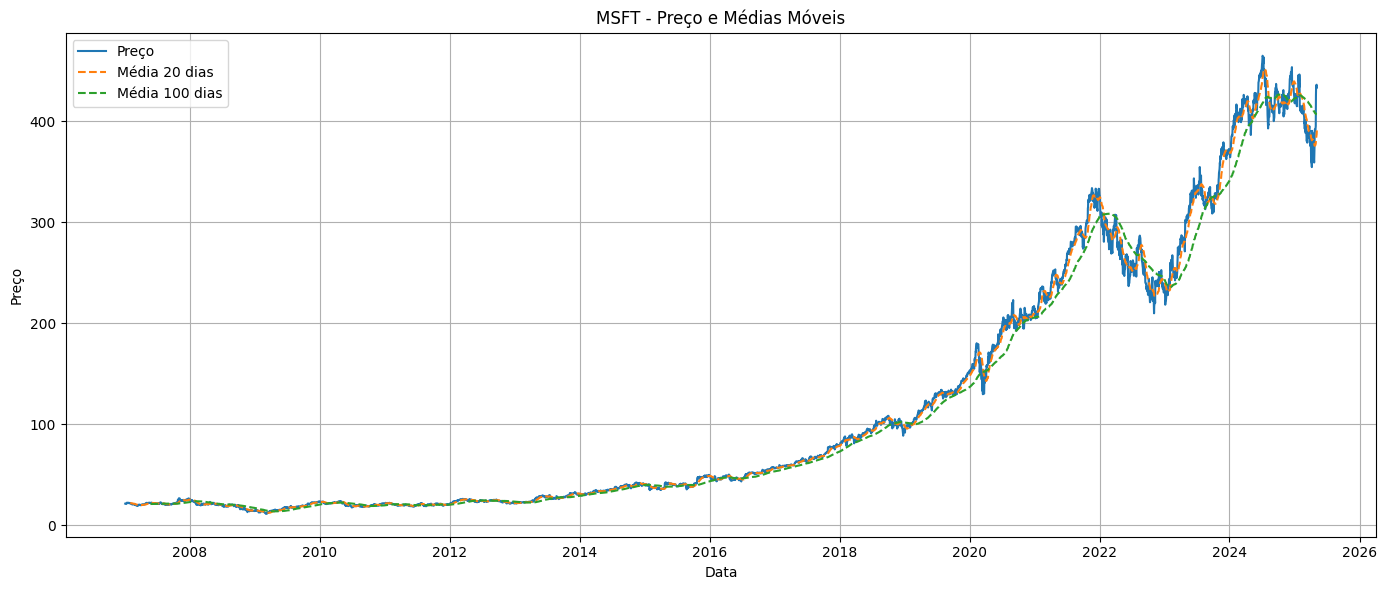

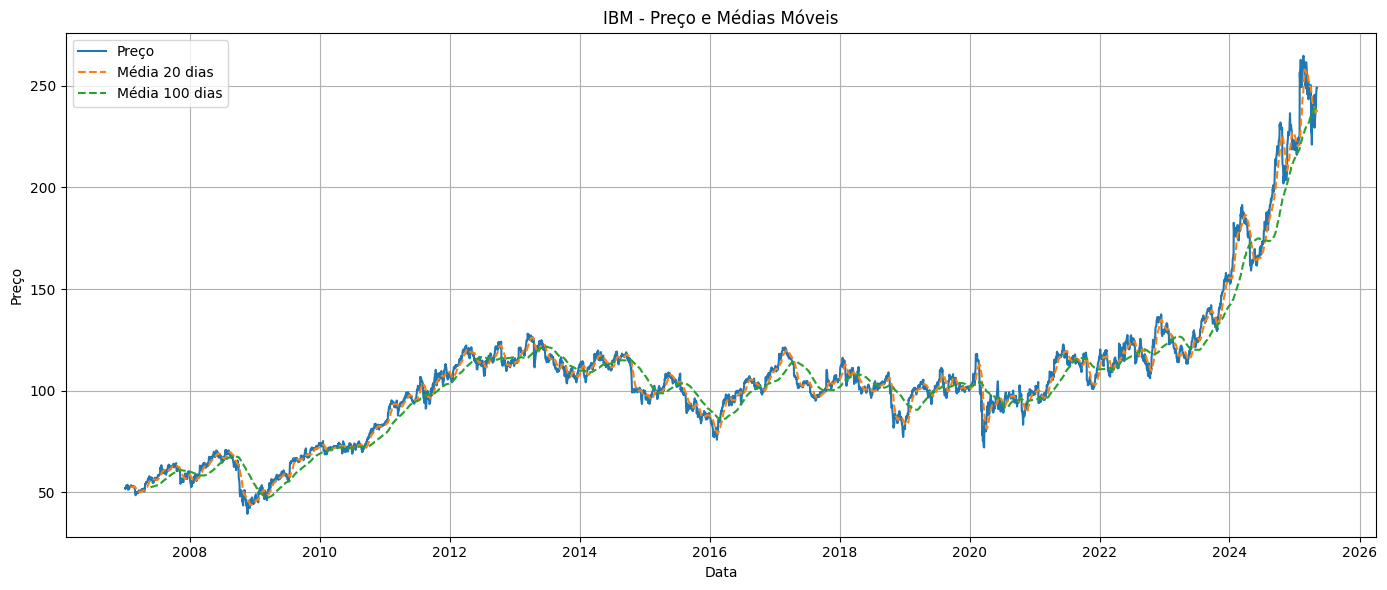

In [25]:


tickers = df_total['ticker'].unique()

for ticker in tickers:
    df_ticker = df_total[df_total['ticker'] == ticker]

    plt.figure(figsize=(14, 6))
    plt.plot(df_ticker.index, df_ticker['Close'], label='Preço', linewidth=1.5)
    plt.plot(df_ticker.index, df_ticker['ma_20'], label='Média 20 dias', linestyle='--')
    plt.plot(df_ticker.index, df_ticker['ma_100'], label='Média 100 dias', linestyle='--')
    plt.title(f'{ticker} - Preço e Médias Móveis')
    plt.xlabel('Data')
    plt.ylabel('Preço')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



## 11. Retorno Acumulado por Ativo

Permite visualizar quem entregou mais retorno ao longo do tempo.

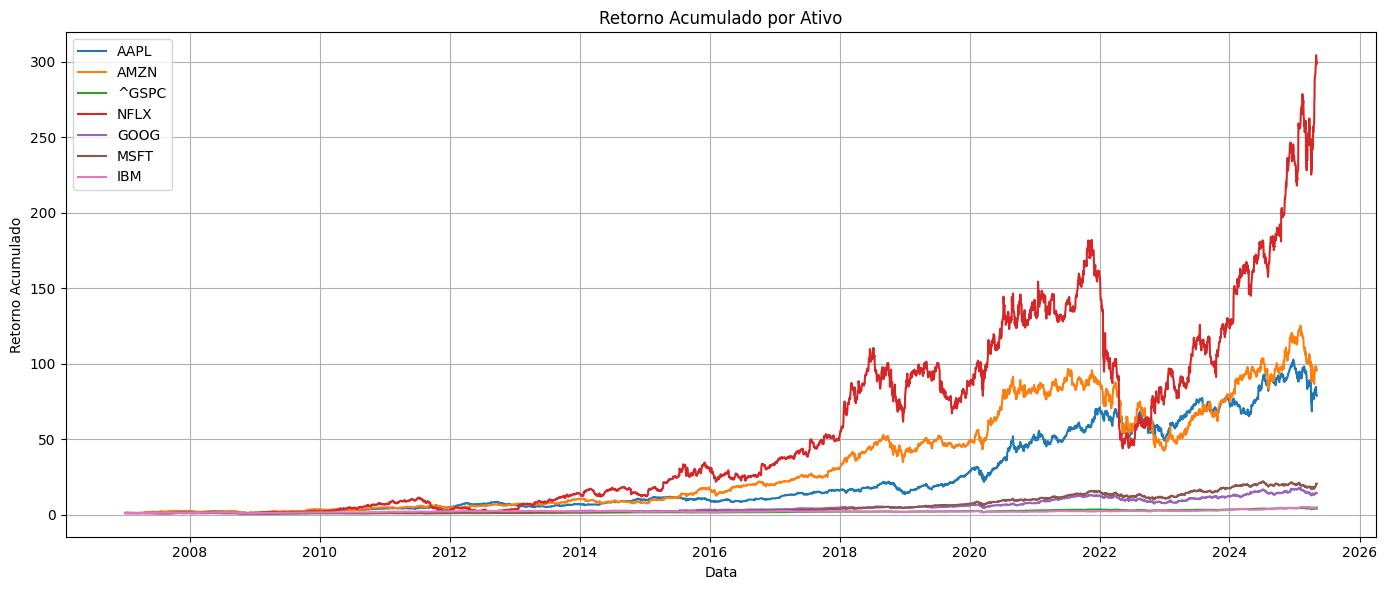

In [20]:
# Calcula o retorno acumulado a partir dos retornos diários
df_total['cum_return'] = df_total.groupby('ticker')['return'].transform(lambda x: (1 + x).cumprod())

# Visualiza o retorno acumulado por ativo
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for ticker in df_total['ticker'].unique():
    df_ticker = df_total[df_total['ticker'] == ticker]
    plt.plot(df_ticker.index, df_ticker['cum_return'], label=ticker)

plt.title('Retorno Acumulado por Ativo')
plt.xlabel('Data')
plt.ylabel('Retorno Acumulado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 12. Ranking de Retorno por Ano

Esse gráfico mostra como cada ativo performou ano a ano e podemos ver

Picos e quedas em anos específicos (ex: crise, tech boom)

Consistência ou volatilidade do desempenho

Quem liderou ou ficou para trás em cada período

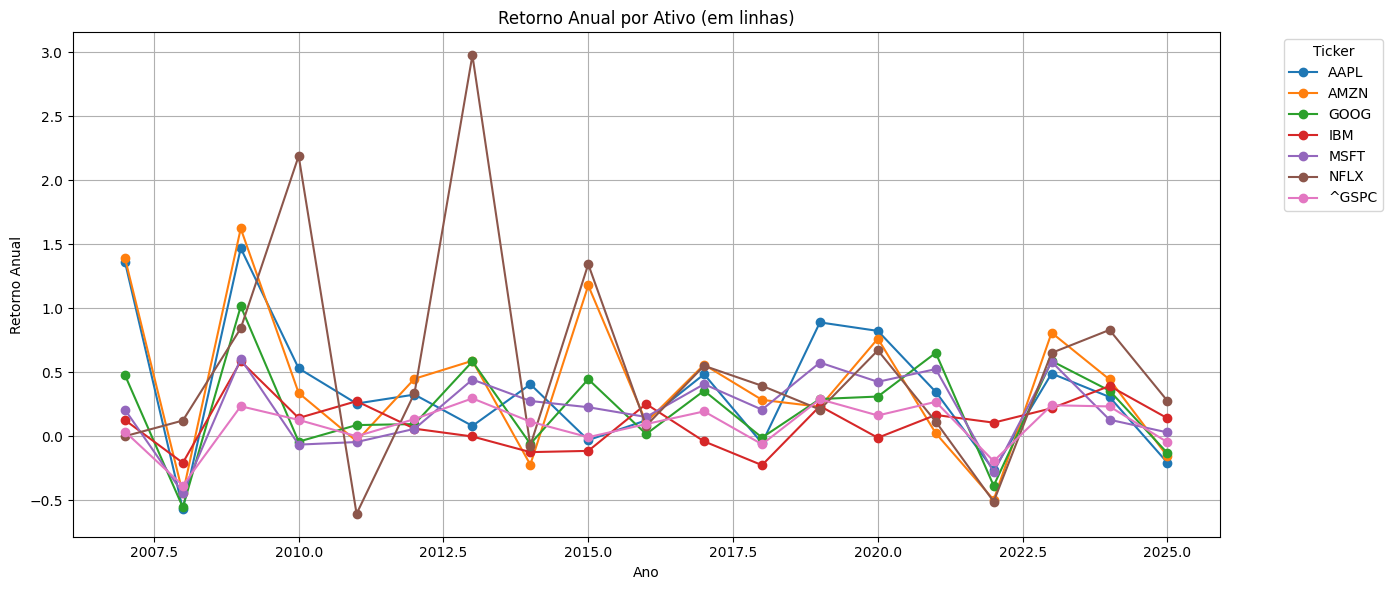

In [23]:
import matplotlib.pyplot as plt

# Garantir cálculo do retorno anual
df_total['year'] = df_total.index.year
annual_return = df_total.groupby(['ticker', 'year'])['return'].apply(lambda x: (1 + x).prod() - 1).reset_index()

# Pivotar para formato "ano x ticker"
pivot_annual = annual_return.pivot(index='year', columns='ticker', values='return')

# Plotar gráfico de linha
pivot_annual.plot(figsize=(14, 6), marker='o')
plt.title('Retorno Anual por Ativo (em linhas)')
plt.ylabel('Retorno Anual')
plt.xlabel('Ano')
plt.grid(True)
plt.legend(title='Ticker', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



## 13. Comparação antes e depois de 2020

In [25]:
# Define períodos
df_total['period'] = df_total.index.to_series().apply(
    lambda x: 'Antes 2020' if x < pd.to_datetime('2020-01-01') else 'Depois 2020'
)

# Calcula média de retorno e volatilidade por ticker e período
comparativo = df_total.groupby(['ticker', 'period'])['return'].agg(['mean', 'std']).reset_index()
comparativo['mean'] = comparativo['mean'] * 252  # anualiza
comparativo['std'] = comparativo['std'] * np.sqrt(252)

# Exibe tabela comparativa
comparativo.rename(columns={'mean': 'Retorno Anualizado', 'std': 'Volatilidade Anualizada'}, inplace=True)
display(comparativo)


,ticker,period,Retorno Anualizado,Volatilidade Anualizada
0,AAPL,Antes 2020,0.306181,0.311974
1,AAPL,Depois 2020,0.246346,0.327964
2,AMZN,Antes 2020,0.371178,0.386581
3,AMZN,Depois 2020,0.196169,0.363179
4,GOOG,Antes 2020,0.174941,0.285114
5,GOOG,Depois 2020,0.224039,0.326614
6,IBM,Antes 2020,0.075696,0.220745
7,IBM,Depois 2020,0.207602,0.275082
8,MSFT,Antes 2020,0.187089,0.269488
9,MSFT,Depois 2020,0.245684,0.307516


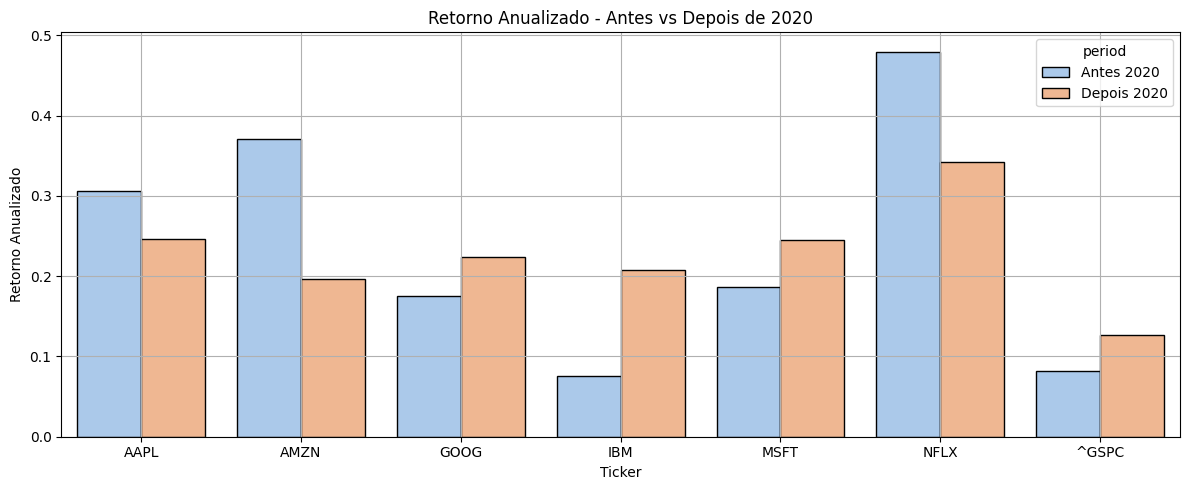

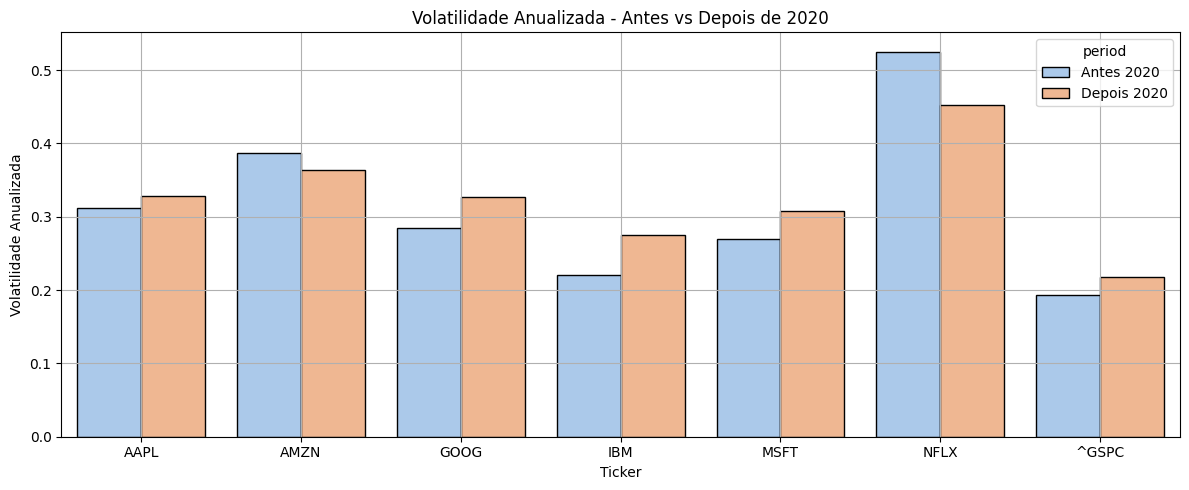

In [28]:


# Garante que os dados estejam no formato certo
comparativo_melt = comparativo.melt(id_vars=['ticker', 'period'], 
                                     value_vars=['Retorno Anualizado', 'Volatilidade Anualizada'],
                                     var_name='Métrica', value_name='Valor')


import seaborn as sns
import matplotlib.pyplot as plt

# Gráfico separado por métrica
for metrica in ['Retorno Anualizado', 'Volatilidade Anualizada']:
    plt.figure(figsize=(12, 5))
    dados = comparativo_melt[comparativo_melt['Métrica'] == metrica]
    sns.barplot(data=dados, x='ticker', y='Valor', hue='period', palette='pastel', edgecolor='black')
    plt.title(f'{metrica} - Antes vs Depois de 2020')
    plt.ylabel(metrica)
    plt.xlabel('Ticker')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Ativos como NFLX e AMZN sofreram mais com o novo cenário pós-2020.

MSFT, GOOG e IBM demonstraram crescimento ou estabilidade, reforçando sua atratividade em portfólios mais defensivos.

Essa análise é útil para orientar estratégias de alocação conforme o contexto macroeconômico

Maior volatilidade no pós-2020 exige mais atenção à gestão de risco.

Ativos como MSFT e GOOG equilibram retorno com risco de forma sólida.

Já ativos como NFLX e AMZN, mesmo com retorno em queda, mantêm alta oscilação — importante alerta para alocação.

## 14. Índice de Sharpe

In [29]:
# Calcular Índice de Sharpe: retorno / volatilidade
comparativo['Sharpe'] = comparativo['Retorno Anualizado'] / comparativo['Volatilidade Anualizada']

# Tabela final organizada
sharpe_tabela = comparativo[['ticker', 'period', 'Retorno Anualizado', 'Volatilidade Anualizada', 'Sharpe']]
sharpe_tabela = sharpe_tabela.sort_values(by=['ticker', 'period'])

# Visualizar
print(sharpe_tabela)


   ticker       period  Retorno Anualizado  Volatilidade Anualizada    Sharpe
0    AAPL   Antes 2020            0.306181                 0.311974  0.981432
1    AAPL  Depois 2020            0.246346                 0.327964  0.751137
2    AMZN   Antes 2020            0.371178                 0.386581  0.960154
3    AMZN  Depois 2020            0.196169                 0.363179  0.540145
4    GOOG   Antes 2020            0.174941                 0.285114  0.613582
5    GOOG  Depois 2020            0.224039                 0.326614  0.685944
6     IBM   Antes 2020            0.075696                 0.220745  0.342912
7     IBM  Depois 2020            0.207602                 0.275082  0.754691
8    MSFT   Antes 2020            0.187089                 0.269488  0.694240
9    MSFT  Depois 2020            0.245684                 0.307516  0.798930
10   NFLX   Antes 2020            0.479818                 0.525258  0.913490
11   NFLX  Depois 2020            0.342076                 0.452

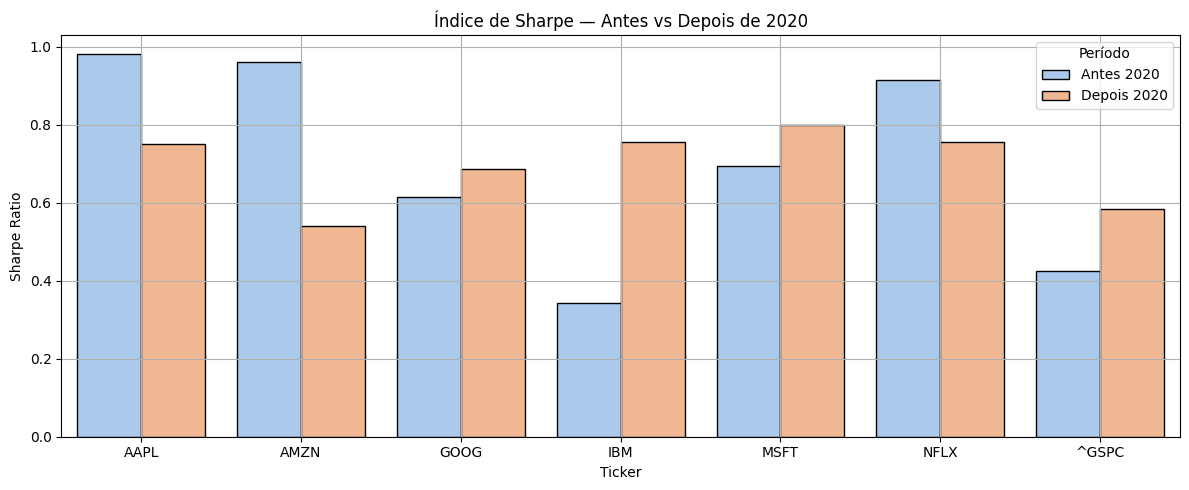

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.barplot(data=sharpe_tabela, x='ticker', y='Sharpe', hue='period', palette='pastel', edgecolor='black')
plt.title('Índice de Sharpe — Antes vs Depois de 2020')
plt.xlabel('Ticker')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Período')
plt.show()


O Índice de Sharpe mede o retorno ajustado ao risco. Ou seja, quanto retorno o investidor obteve por unidade de volatilidade. Quanto maior, melhor.

Ativos que mantiveram ou aumentaram o Sharpe (como MSFT, IBM e GOOG) podem ser considerados mais confiáveis em contextos voláteis.

A queda do Sharpe em AAPL, AMZN e NFLX alerta que esses ativos passaram a entregar menos retorno proporcional ao risco.

Esse tipo de análise é essencial para estratégias de alocação baseadas em eficiência e não apenas em retorno absoluto.